In [1]:
from UTILITY_quickstart import *

In [2]:
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch.yml")
importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch.yml")

In [3]:
csrTF = False
evalElement = "PENT"


inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
bunchCount = importedDefaultSettings["bunchCount"]
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e5,
)

setLattice(tao, **importedDefaultSettings)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 100000.0


In [4]:
assertBC14Energy = importedDefaultSettings["assertBC14Energy"]
assertBC20Energy = importedDefaultSettings["assertBC20Energy"]
centerBC14 = importedDefaultSettings["centerBC14"] 
centerBC20 = importedDefaultSettings["centerBC20"] 
centerMFFF = importedDefaultSettings["centerMFFF"] 

# Track to start of BC20

In [5]:
checkpointElement = "CB1LE" #Shortly downstream of BEGBC20; there's an intervening dipole though

trackBeam(tao, 
          trackStart = "L0AFEND", 
          trackEnd = checkpointElement, 
          centerBC14 = centerBC14, 
          centerBC20 = centerBC20, 
          #centerMFFF = centerMFFF, 
          assertBC14Energy = assertBC14Energy, 
          assertBC20Energy = assertBC20Energy,  
          verbose = True
         )

Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = CB1LE
Set track_end = BEGBC14_1
Tracking!
Also setting BC14 energy = 4.5 GeV, from 4.392628258821399 GeV
Beam centered at BEGBC14 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC14_1, track_end = CB1LE
Set track_end = BEGBC20
Tracking!
Also setting BC20 energy = 10.0 GeV, from 9.914743199139872 GeV
Beam centered at BEGBC20 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC20, track_end = CB1LE
Tracking!
trackBeam() exiting


In [6]:
PInit = getBeamAtElement(tao, checkpointElement)
makeBeamActiveBeamFile(PInit)

# Track to end

In [7]:
trackBeam(tao, 
          trackStart = checkpointElement, 
          trackEnd = "end", 
          #centerBC14 = centerBC14, 
          #centerBC20 = centerBC20, 
          centerMFFF = centerMFFF, 
          #assertBC14Energy = assertBC14Energy, 
          #assertBC20Energy = assertBC20Energy,  
          verbose = True
         )

Loaded activeBeamFile.h5
Set track_start = CB1LE, track_end = end
Tracking!
trackBeam() exiting


In [8]:
savedData = {}

evalElement = "PENT"
P = getBeamAtElement(tao, evalElement)

if bunchCount == 1:
    PDrive = P.copy()
    beamsToEvaluate = ["PDrive"]
elif bunchCount == 2:
    PDrive, PWitness = getDriverAndWitness(P)
    beamsToEvaluate = ["PDrive", "PWitness"]


if evalElement == "MFFF":
    #MFFF lucretia live model lattice 2024-10-16
    targetBetaX = 11.6
    targetBetaY = 25.2
    targetAlphaX = -0.64
    targetAlphaY = -1.6

if evalElement == "PENT":
    #These are the wishful twiss specs
    targetBetaX = 0.5
    targetBetaY = 0.5
    targetAlphaX = 0.0
    targetAlphaY = 0.0


for PActiveStr in beamsToEvaluate:
    PActive = locals()[PActiveStr]

    
    # for val in ["mean_x", "mean_y", "sigma_x", "sigma_y", "mean_xp", "mean_yp"]:
    #     savedData[f"{PActiveStr}_{val}"] = PActive[val]

    
    savedData[f"{PActiveStr}_median_x"] = np.median(PActive.x)
    savedData[f"{PActiveStr}_median_y"] = np.median(PActive.y)

    savedData[f"{PActiveStr}_median_xp"] = np.median(PActive.xp)
    savedData[f"{PActiveStr}_median_yp"] = np.median(PActive.yp)
    
    savedData[f"{PActiveStr}_sigmaSI90_x"] = smallestIntervalImpliedSigma(PActive.x, percentage = 0.90)
    savedData[f"{PActiveStr}_sigmaSI90_y"] = smallestIntervalImpliedSigma(PActive.y, percentage = 0.90)
    savedData[f"{PActiveStr}_sigmaSI90_z"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

    savedData[f"{PActiveStr}_sigmaSI90_xp"] = smallestIntervalImpliedSigma(PActive.xp, percentage = 0.90)
    savedData[f"{PActiveStr}_sigmaSI90_yp"] = smallestIntervalImpliedSigma(PActive.yp, percentage = 0.90)

    savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
    savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

    savedData[f"{PActiveStr}_norm_emit_x"] = PActive["norm_emit_x"]
    savedData[f"{PActiveStr}_norm_emit_y"] = PActive["norm_emit_y"]

    if bunchCount == 2:
        savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

    savedData[f"{PActiveStr}_charge_nC"] = PActive.charge * 1e9


    PActiveTwiss = PActive.twiss(plane = "x", fraction = 0.9) | PActive.twiss(plane = "y", fraction = 0.9)

    savedData[f"{PActiveStr}_BMAG_x"] = calcBMAG(targetBetaX, targetAlphaX, PActiveTwiss["beta_x"], PActiveTwiss["alpha_x"])
    savedData[f"{PActiveStr}_BMAG_y"] = calcBMAG(targetBetaY, targetAlphaY, PActiveTwiss["beta_y"], PActiveTwiss["alpha_y"])

    # Get BMAGs by energy slice
    slicedBeamlets = sliceBeam( PActive , sortKey = "pz", numBeamlets = 5 )

    slicedTwiss =  [ ( beamlet.twiss(plane = "x", fraction = 0.9) | beamlet.twiss(plane = "y", fraction = 0.9) ) for beamlet in slicedBeamlets ] 
    
    savedData[f"{PActiveStr}_sliced_BMAG_x"] = [ calcBMAG(targetBetaX, targetAlphaX, beamletTwiss["beta_x"], beamletTwiss["alpha_x"]) for beamletTwiss in slicedTwiss ]
    savedData[f"{PActiveStr}_sliced_BMAG_y"] = [ calcBMAG(targetBetaY, targetAlphaY, beamletTwiss["beta_y"], beamletTwiss["alpha_y"]) for beamletTwiss in slicedTwiss ]

if bunchCount == 2:
    savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

    savedData["transverseCentroidOffset"] = np.sqrt(
            (savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + 
            (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2
        )

savedData["lostChargeFraction"] = 1 - (P.charge / PInit.charge)

In [9]:
if bunchCount == 2:
    print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")
    
    print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2) :.3g} um""")
    print(f"""Angular misalignment: \t{1e3*np.sqrt((savedData["PDrive_median_xp"] - savedData["PWitness_median_xp"])**2 + (savedData["PDrive_median_yp"] - savedData["PWitness_median_yp"])**2) :.3g} mrad""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
if bunchCount == 2:
    print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * savedData["PDrive_sigmaSI90_x"] :.3g} × {1e6 * savedData["PDrive_sigmaSI90_y"] :.3g} × {1e6 * savedData["PDrive_sigmaSI90_z"] :.3g} um""")
if bunchCount == 2:
    print(f"""Witness sigma_x,y,z: \t{1e6 * savedData["PWitness_sigmaSI90_x"] :.3g} × {1e6 * savedData["PWitness_sigmaSI90_y"] :.3g} × {1e6 * savedData["PWitness_sigmaSI90_z"] :.3g} um""")



print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
if bunchCount == 2: 
    print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g} × {1e6 * PDrive["sigma_y"] :.3g} × {1e6 * PDrive["sigma_z"] :.3g} um""")
if bunchCount == 2:
    print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g} × {1e6 * PWitness["sigma_y"] :.3g} × {1e6 * PWitness["sigma_z"] :.3g} um""")


Emittances and sigmas - implied by 90% charge
Driver emittance: 	7.46 × 2.93 um-rad
Driver sigma_x,y,z: 	16 × 9.2 × 3.71 um

Emittances and sigmas - literal standard deviation
Driver emittance: 	14.8 × 4.64 um-rad
Driver sigma_x,y,z: 	23.1 × 11.3 × 8.26 um


Drive:


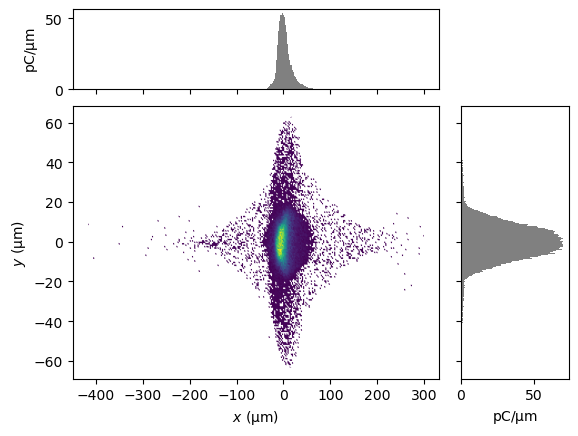

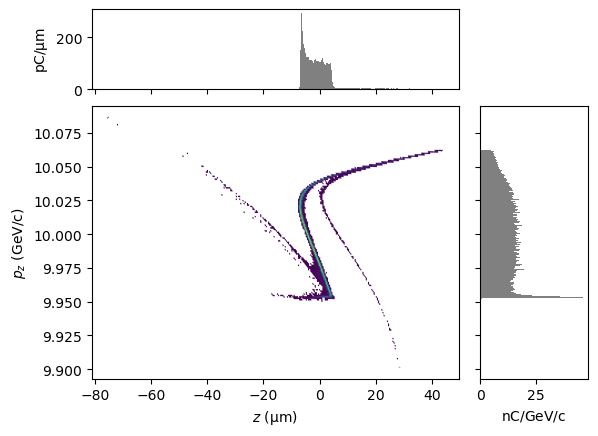

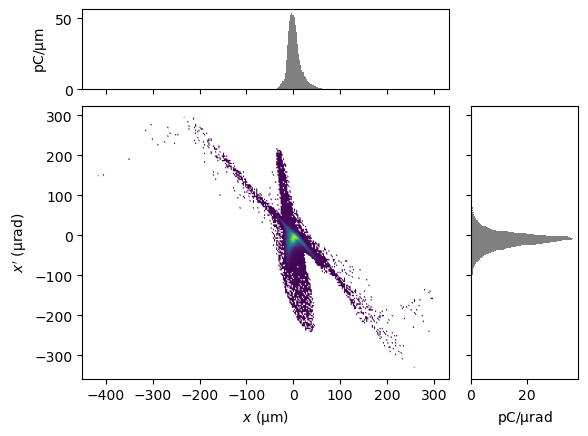

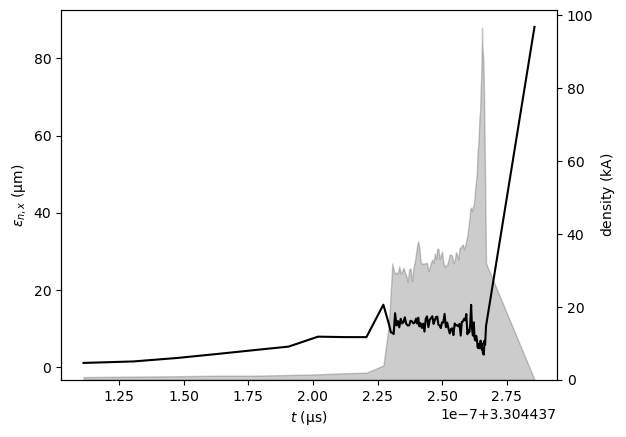

<Figure size 640x480 with 0 Axes>

In [10]:
print("Drive:")
display(plotMod(PDrive, 'x', 'y',  bins=300))
if bunchCount == 2:
    print("Witness:")
    display(plotMod(PWitness, 'x', 'y',  bins=300))
    
display(plotMod(PDrive, 'z', 'pz', bins=300))

display(plotMod(PDrive, 'x', 'xp', bins=300))
display(slicePlotMod(PDrive, 'norm_emit_x', slice_key = "t", n_slice=100))
plt.clf()

## Testing out assembling and exporting figures

In [11]:
# fig = plotMod(PDrive, 'x', 'xp',  bins=300)
# fig.savefig('myplot1.png', dpi=300, bbox_inches='tight')

# fig = plotMod(PDrive, 'y', 'yp',  bins=300)
# fig.savefig('myplot2.png', dpi=300, bbox_inches='tight')

# fig = plotMod(PDrive, 'z', 'energy',  bins=300)
# fig.savefig('myplot3.png', dpi=300, bbox_inches='tight')


In [12]:
# from PIL import Image

# # Assume you already have three separate PNG files saved by calling plotMod() individually:
# # myplot1.png, myplot2.png, myplot3.png

# images = [Image.open(fname) for fname in ['myplot1.png', 'myplot2.png', 'myplot3.png']]

# # Get total width and the max height among the three images
# widths, heights = zip(*(i.size for i in images))
# total_width = sum(widths)
# max_height = max(heights)

# # Create a new blank image with enough width and max height
# new_im = Image.new('RGB', (total_width, max_height))

# x_offset = 0
# for im in images:
#     new_im.paste(im, (x_offset, 0))
#     x_offset += im.width

# new_im.save('combined_row.png')

In [13]:
# from PIL import Image

# def makeFigureRow(P, name):
#     fig = plotMod(P, 'x', 'xp',  bins=300, xlim=(-100e-6,100e-6), ylim=(-600e-6,200e-6) )
#     fig.savefig('myplot1.png', dpi=300, bbox_inches='tight')
    
#     fig = plotMod(P, 'y', 'yp',  bins=300, xlim=(-50e-6,50e-6), ylim=(-100e-6,100e-6))
#     fig.savefig('myplot2.png', dpi=300, bbox_inches='tight')
    
#     fig = plotMod(P, 'z', 'energy',  bins=300, xlim=(-150e-6,50e-6), ylim=(9.6e9,10.1e9))
#     fig.savefig('myplot3.png', dpi=300, bbox_inches='tight')


    
#     images = [Image.open(fname) for fname in ['myplot1.png', 'myplot2.png', 'myplot3.png']]

#     # Get total width and the max height among the three images
#     widths, heights = zip(*(i.size for i in images))
#     total_width = sum(widths)
#     max_height = max(heights)
    
#     # Create a new blank image with enough width and max height
#     new_im = Image.new('RGB', (total_width, max_height))
    
#     x_offset = 0
#     for im in images:
#         new_im.paste(im, (x_offset, 0))
#         x_offset += im.width
    
#     new_im.save(f'{name}.png')

In [14]:
# makeFigureRow(PDrive, "demo")

In [15]:
# PDrive.twiss()

In [16]:
# PDrive.write("demo.h5")

# Automate

## Turning the usual into a function

In [17]:
def getBeamSpecs(P):
    savedData = {}
    
    if bunchCount == 1:
        PDrive = P.copy()
        beamsToEvaluate = ["PDrive"]
    elif bunchCount == 2:
        PDrive, PWitness = getDriverAndWitness(P)
        beamsToEvaluate = ["PDrive", "PWitness"]
    
    
    # if evalElement == "MFFF":
    #     #MFFF lucretia live model lattice 2024-10-16
    #     targetBetaX = 11.6
    #     targetBetaY = 25.2
    #     targetAlphaX = -0.64
    #     targetAlphaY = -1.6
    
    # if evalElement == "PENT":
    #     #These are the wishful twiss specs
    #     targetBetaX = 0.5
    #     targetBetaY = 0.5
    #     targetAlphaX = 0.0
    #     targetAlphaY = 0.0
    
    
    for PActiveStr in beamsToEvaluate:
        PActive = locals()[PActiveStr]
    
        
        # for val in ["mean_x", "mean_y", "sigma_x", "sigma_y", "mean_xp", "mean_yp"]:
        #     savedData[f"{PActiveStr}_{val}"] = PActive[val]
    
        
        savedData[f"{PActiveStr}_median_x"] = np.median(PActive.x)
        savedData[f"{PActiveStr}_median_y"] = np.median(PActive.y)
    
        savedData[f"{PActiveStr}_median_xp"] = np.median(PActive.xp)
        savedData[f"{PActiveStr}_median_yp"] = np.median(PActive.yp)
        
        savedData[f"{PActiveStr}_sigmaSI90_x"] = smallestIntervalImpliedSigma(PActive.x, percentage = 0.90)
        savedData[f"{PActiveStr}_sigmaSI90_y"] = smallestIntervalImpliedSigma(PActive.y, percentage = 0.90)
        savedData[f"{PActiveStr}_sigmaSI90_z"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)
    
        savedData[f"{PActiveStr}_sigmaSI90_xp"] = smallestIntervalImpliedSigma(PActive.xp, percentage = 0.90)
        savedData[f"{PActiveStr}_sigmaSI90_yp"] = smallestIntervalImpliedSigma(PActive.yp, percentage = 0.90)
    
        savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
        savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)
    
        savedData[f"{PActiveStr}_norm_emit_x"] = PActive["norm_emit_x"]
        savedData[f"{PActiveStr}_norm_emit_y"] = PActive["norm_emit_y"]
    
        if bunchCount == 2:
            savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)
    
        savedData[f"{PActiveStr}_charge_nC"] = PActive.charge * 1e9
    
    
        PActiveTwiss = PActive.twiss(plane = "x", fraction = 0.9) | PActive.twiss(plane = "y", fraction = 0.9)
    
        # savedData[f"{PActiveStr}_BMAG_x"] = calcBMAG(targetBetaX, targetAlphaX, PActiveTwiss["beta_x"], PActiveTwiss["alpha_x"])
        # savedData[f"{PActiveStr}_BMAG_y"] = calcBMAG(targetBetaY, targetAlphaY, PActiveTwiss["beta_y"], PActiveTwiss["alpha_y"])
    
        # Get BMAGs by energy slice
        #slicedBeamlets = sliceBeam( PActive , sortKey = "pz", numBeamlets = 5 )
    
        #slicedTwiss =  [ ( beamlet.twiss(plane = "x", fraction = 0.9) | beamlet.twiss(plane = "y", fraction = 0.9) ) for beamlet in slicedBeamlets ] 
        
        #savedData[f"{PActiveStr}_sliced_BMAG_x"] = [ calcBMAG(targetBetaX, targetAlphaX, beamletTwiss["beta_x"], beamletTwiss["alpha_x"]) for beamletTwiss in slicedTwiss ]
        #savedData[f"{PActiveStr}_sliced_BMAG_y"] = [ calcBMAG(targetBetaY, targetAlphaY, beamletTwiss["beta_y"], beamletTwiss["alpha_y"]) for beamletTwiss in slicedTwiss ]
    
    if bunchCount == 2:
        savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]
    
        savedData["transverseCentroidOffset"] = np.sqrt(
                (savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + 
                (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2
            )
    
    savedData["lostChargeFraction"] = 1 - (P.charge / PInit.charge)

    return savedData|PActiveTwiss

In [18]:
getBeamSpecs(P)

{'PDrive_median_x': 2.086936962640342e-07,
 'PDrive_median_y': -3.033248980133725e-08,
 'PDrive_median_xp': -1.1112602741059422e-05,
 'PDrive_median_yp': 1.765190049475334e-07,
 'PDrive_sigmaSI90_x': 1.5952681934075004e-05,
 'PDrive_sigmaSI90_y': 9.198149861320303e-06,
 'PDrive_sigmaSI90_z': 3.7055933794498134e-06,
 'PDrive_sigmaSI90_xp': 3.233481067684975e-05,
 'PDrive_sigmaSI90_yp': 1.75019673942796e-05,
 'PDrive_emitSI90_x': 7.459657041726667e-06,
 'PDrive_emitSI90_y': 2.928211948215966e-06,
 'PDrive_norm_emit_x': 1.482204475859779e-05,
 'PDrive_norm_emit_y': 4.640252109727964e-06,
 'PDrive_charge_nC': 1.5997440000000005,
 'lostChargeFraction': 0.0,
 'alpha_x': 0.9335868403680607,
 'beta_x': 0.7833880270569055,
 'gamma_x': 2.3890898556871445,
 'emit_x': 1.7267971882476279e-10,
 'eta_x': -0.002188064773262667,
 'etap_x': -0.0017155380670360258,
 'norm_emit_x': 3.379218715910352e-06,
 'alpha_y': 0.8523327057643502,
 'beta_y': 0.6380730733967288,
 'gamma_y': 2.705757558652105,
 'emit_y

## Getting base case

In [19]:
import json 

outputFolder = "2024-12-16_sextupoleStudy"
with open(f"{outputFolder}/base.json", "w") as outfile: 
    json.dump(getBeamSpecs(P), outfile)

In [20]:
PDrive.write(f"{outputFolder}/base.h5")

## Parameter scan

In [21]:
nominalSextupoleSettings = {
    "S1EL_xOffset" : importedDefaultSettings["S1EL_xOffset"],
    "S1EL_yOffset" : importedDefaultSettings["S1EL_yOffset"],
    "S2EL_xOffset" : importedDefaultSettings["S2EL_xOffset"],
    "S2EL_yOffset" : importedDefaultSettings["S2EL_yOffset"],
    "S2ER_xOffset" : importedDefaultSettings["S2ER_xOffset"],
    "S2ER_yOffset" : importedDefaultSettings["S2ER_yOffset"],
    "S1ER_xOffset" : importedDefaultSettings["S1ER_xOffset"],
    "S1ER_yOffset" : importedDefaultSettings["S1ER_yOffset"],
}

In [22]:
perturbSize = 100e-6

#activeKey = "S1EL_xOffset"

for activeKey in nominalSextupoleSettings:
    for sign in ["plus", "minus"]:
        setLattice(tao, **( importedDefaultSettings | { activeKey : nominalSextupoleSettings[activeKey] + ( 1 if sign == "plus" else -1 ) * perturbSize}  ) )
        
        trackBeam(tao, 
                  trackStart = checkpointElement, 
                  trackEnd = "end", 
                  #centerBC14 = centerBC14, 
                  #centerBC20 = centerBC20, 
                  centerMFFF = centerMFFF, 
                  #assertBC14Energy = assertBC14Energy, 
                  #assertBC20Energy = assertBC20Energy,  
                  verbose = True
                 )
    
        P = getBeamAtElement(tao, "PENT")
        
        with open(f"{outputFolder}/{activeKey}_{sign}.json", "w") as outfile: 
            json.dump(getBeamSpecs(P), outfile)
        
        P.write(f"{outputFolder}/{activeKey}_{sign}.h5")

Loaded activeBeamFile.h5
Set track_start = CB1LE, track_end = end
Tracking!
trackBeam() exiting
Loaded activeBeamFile.h5
Set track_start = CB1LE, track_end = end
Tracking!
trackBeam() exiting
Loaded activeBeamFile.h5
Set track_start = CB1LE, track_end = end
Tracking!
trackBeam() exiting
Loaded activeBeamFile.h5
Set track_start = CB1LE, track_end = end
Tracking!
trackBeam() exiting
Loaded activeBeamFile.h5
Set track_start = CB1LE, track_end = end
Tracking!
trackBeam() exiting
Loaded activeBeamFile.h5
Set track_start = CB1LE, track_end = end
Tracking!
trackBeam() exiting
Loaded activeBeamFile.h5
Set track_start = CB1LE, track_end = end
Tracking!
trackBeam() exiting
Loaded activeBeamFile.h5
Set track_start = CB1LE, track_end = end
Tracking!
trackBeam() exiting
Loaded activeBeamFile.h5
Set track_start = CB1LE, track_end = end
Tracking!
trackBeam() exiting
Loaded activeBeamFile.h5
Set track_start = CB1LE, track_end = end
Tracking!
trackBeam() exiting
Loaded activeBeamFile.h5
Set track_start